In [5]:
!pip install datasets

In [6]:
import datasets
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score


In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, TimeDistributed, Concatenate
from tensorflow.keras.models import Model
from transformers import BertTokenizer
from datasets import load_dataset

In [8]:
from tensorflow.keras.layers import Layer, Input, Embedding, LSTM, TimeDistributed, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow import keras  # Import keras module


In [23]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [10]:
import pandas as pd
from datasets import load_dataset

# Load a different dataset (e.g., AG News dataset)
train_dataset = load_dataset("ag_news", split='train')
test_dataset = load_dataset("ag_news", split='test')

# Select a subset of the dataset
dataset_train = train_dataset.select(range(1000))
dataset_test = test_dataset.select(range(50))

# Convert to Pandas DataFrame
train_df = dataset_train.to_pandas()
test_df = dataset_test.to_pandas()

# Print the DataFrames
print("Training DataFrame:")
print(train_df.head())  # Display first 5 rows

print("\nTest DataFrame:")
print(test_df.head())  # Display first 5 rows


Training DataFrame:
                                                text  label
0  Wall St. Bears Claw Back Into the Black (Reute...      2
1  Carlyle Looks Toward Commercial Aerospace (Reu...      2
2  Oil and Economy Cloud Stocks' Outlook (Reuters...      2
3  Iraq Halts Oil Exports from Main Southern Pipe...      2
4  Oil prices soar to all-time record, posing new...      2

Test DataFrame:
                                                text  label
0  Fears for T N pension after talks Unions repre...      2
1  The Race is On: Second Private Team Sets Launc...      3
2  Ky. Company Wins Grant to Study Peptides (AP) ...      3
3  Prediction Unit Helps Forecast Wildfires (AP) ...      3
4  Calif. Aims to Limit Farm-Related Smog (AP) AP...      3


In [11]:
# Parameters
latent_dim = 300
embedding_dim = 100
max_input_len = 400
max_output_len = 100
batch_size = 8
epochs = 50

# Load Dataset
def load_dataset_fn(dataset_name, config_name):
    dataset = load_dataset(dataset_name, config_name)
    return dataset['train'], dataset['validation']

train_data, val_data = load_dataset_fn("cnn_dailymail", "3.0.0")

# Limit the dataset to 100 samples
train_data = train_data.select(range(1000))
val_data = val_data.select(range(250))

# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', use_fast=True)
x_voc = tokenizer.vocab_size  # Vocabulary size for articles
y_voc = tokenizer.vocab_size  # Vocabulary size for summaries

# Preprocessing
def preprocess_data(data, tokenizer, max_input_len, max_output_len):
    input_ids = tokenizer.batch_encode_plus(
        data['article'],
        max_length=max_input_len,
        padding='max_length',
        truncation=True,
        return_tensors="np"
    )['input_ids']

    target_ids = tokenizer.batch_encode_plus(
        data['highlights'],
        max_length=max_output_len,
        padding='max_length',
        truncation=True,
        return_tensors="np"
    )['input_ids']

    return input_ids, target_ids

train_input_ids, train_target_ids = preprocess_data(train_data, tokenizer, max_input_len, max_output_len)
val_input_ids, val_target_ids = preprocess_data(val_data, tokenizer, max_input_len, max_output_len)

# Data Generators
def data_generator(input_ids, target_ids, batch_size):
    while True:
        for i in range(0, len(input_ids), batch_size):
            batch_input_ids = input_ids[i:i + batch_size]
            batch_decoder_input_ids = target_ids[i:i + batch_size, :-1]  # Decoder input
            batch_decoder_target_ids = target_ids[i:i + batch_size, 1:]  # Decoder target

            # Ensure they are numpy arrays
            yield (
                (np.array(batch_input_ids, dtype=np.int32), np.array(batch_decoder_input_ids, dtype=np.int32)),
                np.array(batch_decoder_target_ids, dtype=np.int32)
            )


train_gen = data_generator(train_input_ids, train_target_ids, batch_size)
val_gen = data_generator(val_input_ids, val_target_ids, batch_size)


README.md:   0%|          | 0.00/15.6k [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [12]:
# Model Definition
# Encoder
encoder_inputs = Input(shape=(max_input_len,))
enc_emb = Embedding(x_voc, embedding_dim, trainable=True)(encoder_inputs)

encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

encoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

encoder_lstm3 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

# Decoder
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(y_voc, embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

import tensorflow as tf

@tf.keras.utils.register_keras_serializable()
class AttentionLayer(Layer):
    def call(self, inputs):
        encoder_out, decoder_out = inputs
        attn_scores = tf.matmul(decoder_out, encoder_out, transpose_b=True)
        attn_weights = tf.nn.softmax(attn_scores, axis=-1)
        context = tf.matmul(attn_weights, encoder_out)
        return context, attn_weights

attn_layer = AttentionLayer()
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concatenate attention and decoder outputs
decoder_concat_input = Concatenate(axis=-1)([decoder_outputs, attn_out])
decoder_dense = TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define Model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

# Compile Model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 400)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 400, 100)       │      3,052,200 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 400, 300),     │        481,200 │ embedding[0][0]        │
│                           │ (None, 300), (None,    │                │                        │
│                           │ 300)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, 400, 300),     │        721,200 │ lstm[0][0]             │
│                           │ (None, 300), (None,    │                │                        │
│                           │ 300)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, None, 100)      │      3,052,200 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ [(None, 400, 300),     │        721,200 │ lstm_1[0][0]           │
│                           │ (None, 300), (None,    │                │                        │
│                           │ 300)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ [(None, None, 300),    │        481,200 │ embedding_1[0][0],     │
│                           │ (None, 300), (None,    │                │ lstm_2[0][1],          │
│                           │ 300)]                  │                │ lstm_2[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_layer           │ [(None, None, 300),    │              0 │ lstm_2[0][0],          │
│ (AttentionLayer)          │ (None, None, 400)]     │                │ lstm_3[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, None, 600)      │              0 │ lstm_3[0][0],          │
│                           │                        │                │ attention_layer[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed          │ (None, None, 30522)    │     18,343,722 │ concatenate[0][0]      │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 26,852,922 (102.44 MB)

 Trainable params: 26,852,922 (102.44 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(train_input_ids, train_target_ids, batch_size),
    output_signature=(
        (
            tf.TensorSpec(shape=(None, max_input_len), dtype=tf.int32),  # Encoder input
            tf.TensorSpec(shape=(None, max_output_len - 1), dtype=tf.int32),  # Decoder input
        ),
        tf.TensorSpec(shape=(None, max_output_len - 1), dtype=tf.int32),  # Decoder target
    )
)

val_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(val_input_ids, val_target_ids, batch_size),
    output_signature=(
        (
            tf.TensorSpec(shape=(None, max_input_len), dtype=tf.int32),
            tf.TensorSpec(shape=(None, max_output_len - 1), dtype=tf.int32),
        ),
        tf.TensorSpec(shape=(None, max_output_len - 1), dtype=tf.int32),
    )
)


In [14]:
steps_per_epoch = len(train_input_ids) // batch_size
validation_steps = len(val_input_ids) // batch_size

history = model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    epochs=epochs
)


Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 224s 2s/step - accuracy: 0.4527 - loss: 5.9452 - val_accuracy: 0.5993 - val_loss: 3.2993
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 210s 2s/step - accuracy: 0.5024 - loss: 3.9032 - val_accuracy: 0.6039 - val_loss: 3.2695
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 209s 2s/step - accuracy: 0.5076 - loss: 3.8332 - val_accuracy: 0.6047 - val_loss: 3.2885
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 210s 2s/step - accuracy: 0.5126 - loss: 3.7559 - val_accuracy: 0.6093 - val_loss: 3.2904
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 209s 2s/step - accuracy: 0.5189 - loss: 3.6613 - val_accuracy: 0.6123 - val_loss: 3.2799
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 210s 2s/step - accuracy: 0.5227 - loss: 3.5610 - val_accuracy: 0.6127 - val_loss: 3.3127
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 209s 2s/step - accuracy: 0.5255 - loss: 3.4575 - val_accuracy: 0.6191 - val_loss: 3.2900
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step - accuracy: 0.5307 - loss: 3.3439 - val_accu

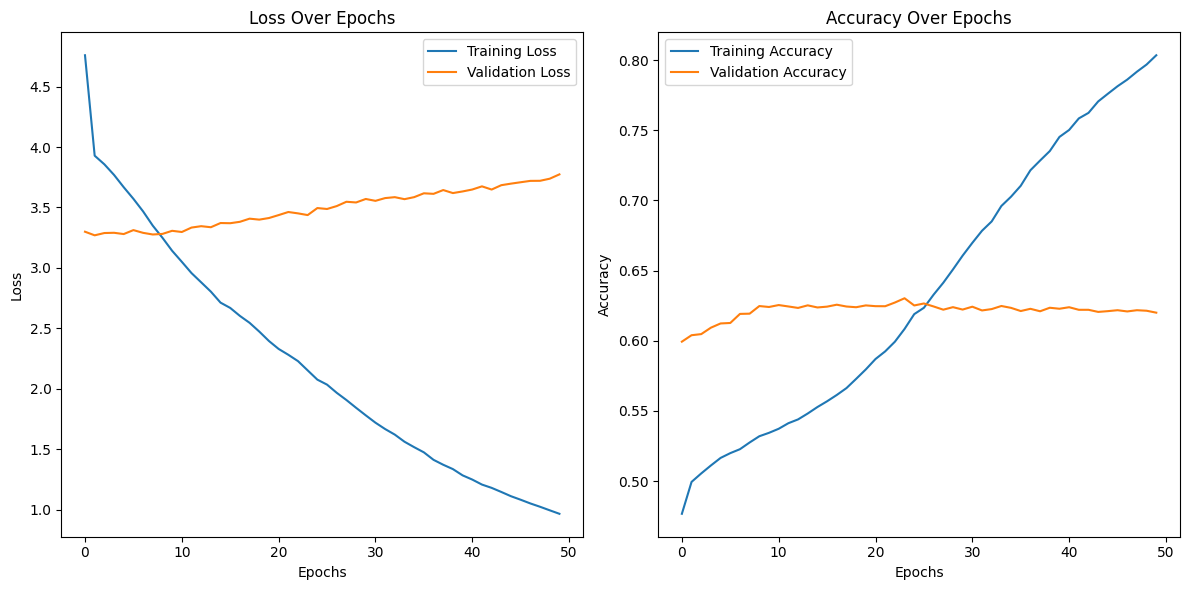

In [19]:
import matplotlib.pyplot as plt

# Extract metrics from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']  # Replace 'accuracy' with 'categorical_accuracy' or 'sparse_categorical_accuracy' if applicable
val_accuracy = history.history['val_accuracy']

# Plot Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [20]:
model.save('/content/sample_data/lstmdata2.h5')

In [21]:
model.save('/content/sample_data/lstmdata2.keras')

In [22]:
import numpy as np

def sample_from_logits(logits, temperature=1.0, top_k=50):
    logits = logits / temperature  # Apply temperature
    logits = np.array(logits)  # Ensure it's a numpy array

    # Apply top-k sampling
    top_k_indices = np.argsort(logits)[-top_k:]
    top_k_logits = logits[top_k_indices]
    top_k_probs = np.exp(top_k_logits) / np.sum(np.exp(top_k_logits))  # Softmax
    selected_token = np.random.choice(top_k_indices, p=top_k_probs)

    return selected_token

def generate_summary(input_text, tokenizer, model, max_input_len, max_output_len, temperature=1.0, top_k=50):
    # Step 1: Tokenize the input text to get the input IDs
    input_ids = tokenizer.encode(input_text, max_length=max_input_len, padding='max_length', truncation=True, return_tensors='np')

    # Step 2: Prepare the decoder input (initialize with <start> token or zeros)
    sample_decoder_input_ids = np.zeros((1, max_output_len - 1), dtype=np.int32)
    sample_decoder_input_ids[0, 0] = tokenizer.pad_token_id  # or use <start> token if defined

    # Step 3: Ensure correct shape for the model (input shape should be (1, max_input_len))
    input_ids = np.squeeze(input_ids, axis=0)  # Shape should be (max_input_len,)

    # Optional: Check if input_ids shape matches expected shape
    if input_ids.shape[0] != max_input_len:
        print(f"Warning: Adjusting input length to match max_input_len ({max_input_len}).")
        input_ids = input_ids[:max_input_len]  # Truncate if needed

    # Step 4: Make the prediction
    predicted_logits = model.predict([input_ids[np.newaxis, :], sample_decoder_input_ids])

    # Step 5: Sample tokens from the logits using temperature and top-k
    predicted_ids = []
    for step in range(max_output_len - 1):
        token_logits = predicted_logits[0][step]  # Get logits for the current timestep
        sampled_token = sample_from_logits(token_logits, temperature=temperature, top_k=top_k)
        predicted_ids.append(sampled_token)

    # Step 6: Decode the predicted output back to text
    predicted_summary = tokenizer.decode(predicted_ids, skip_special_tokens=True)

    if not predicted_summary:
        print("Warning: The predicted summary is empty. Check model and output generation.")

    return predicted_summary

# Example usage
input_text = '''Years ago, my favorite cracker was Keebler Club. One day, I saw the multi-grain version and thought I’d try it,
    especially since I enjoy whole-grain breads and am trying to lower cholesterol. I couldn’t believe the multi-grain
    version actually tastes better than the original! I bought several boxes of these crackers and always keep some on hand.
    I use them for Asian tuna salad, with Inglehoffer sweet honey mustard, or as spreads for soups. They are tasty crackers.
'''
summary = generate_summary(input_text, tokenizer, model, max_input_len=400, max_output_len=99, temperature=0.7, top_k=50)
print("Generated Summary: ", summary)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Generated Summary:  germany re four attack two tony ll william if t he s t " objections to with enough had s family will go'asked took asked police in didn just half experts was william clinton germany pu four family enough of reportedly to is t to with four would had clinton william hospitalized in it calls in to clinton re reporter of wii both both two doesn defense asked four william asked enough germany in william i clinton took it system two it adds would didn
